# Etherium Database: Basic Implementation


## TOC
* [Database Design](#database-design)
    * [Schema](#schema)
* [Description of Attributes](#Description-of-Attributes)
    * [Block Attributes](#Block-Attributes)
    * [Transaction Attributes]()
* [Classes]()
* [Exploratory Data Analysis (EDA)](#)
    * [How secure is Etherium blockchain from 51% attack?](#)
    * [How rewarding is it to mine a block?](#)
    * [Transactions per block](#)
    * [Eth value transferred per transaction](#)
    * [Wallet balance calculation](#)


Curious about doing analytics or detectve work in Etherium? Having access to a full fledged database of the blockchain is a must. Although a few companies provide this type of access, I will demonstrate the basic steps to build your own private database of the blockchain.

For this excercise I will use web3 to download blocks from a node. Running a private etherium node will be ideal, but it is resource intensive. Alternatively, one can use a public node from Alchemy or Infura. Blocks are stored in a sqlite3 database. There is also a basic web application to execute SQL queries. I will also present some basic analytics in this notebook.


## Database Design <a class="anchor" id="database-design"></a>

### Schema <a class="anchor" id="schema"></a>

Database schema consists of two tables, named Block and Transaction. *blockHash* is the primary key of Block. *txHash* is the primary key of Transaction. Transaction table also has *blockHash*, which serves as foreign key to index into Block table. In addition, *blockHash* of Block table indexes rows of Transaction table for quick lookup. To learn more about the attributes within a block or transaction, please refer to the [yellow paper](https://ethereum.github.io/yellowpaper/paper.pdf).

The relation between Block and Transaction is 1:Many, specifically, 1:greater_than_1. Each block contains a list of transaction hashes. However these hashes are not stored in Block table since it causes redundancy. Instead, indexing is used to achieve the effect of quick lookup of transaction hashes given a *blockHash*. Each transaction is retrieved separately and attributes specific to transaction are stored in Transaction table.

**Table Name:** Block    
**Primary Key:** blockNumber   
**Foreign Key:** none 

Block(**blockNumber**, blockHash, difficulty, extraData, gasLimit, gasUsed, logsBloom, miner, mixHash, nonce, parentHash, receiptsRoot, sha3Uncles, size, stateRoot, timestamp, totalDifficulty, transactionsRoot, uncles)

**Table Name:** Transaction    
**Primary Key:** txHash    
**Foreign Key:** blockNumber    

Transaction(**txHash**, *blockNumber*, blockHash, txFrom, gas, gasPrice, input, nonce, r, s, txTo, transactionIndex, v, value)

### Entity Relationship Diagram (ERD)

ERD illustrates the schema with the help of one-to-many relation.



```
+--------------------+                         +--------------------+   
| Block              |                         | Transaction        |
|--------------------|                         |--------------------|
| *blockNumber*      |                         | *txHash*           |
| blockHash          |            x            | blockHash          |
| difficulty         |          /   \          | txFrom             |
| extraData          |        /       \        | gas                |
| gasLimit           |  1   /           \ 0-n /| gasPrice           |
| gasUsed            |-||--|  contains   |---o-| input              |
| logsBloom          |      \           /     \| nonce              |
| miner              |        \       /        | blockNumber        |
| mixHash            |          \   /          | r                  |
| nonce              |            v            | s                  |  
| parentHash         |                         | txTo               |
| receiptsRoot       |                         | transactionIndex   |
| sha3Uncles         |                         | v                  |
| size               |                         | value              |
| stateRoot          |                         +--------------------+
| timestamp          |                       
| totalDifficulty    |                       
| transactionsRoot   |                       
| uncles             |                       
+--------------------+                       
```                                  

## Description of Attributes <a class="anchor" id="Description-of-Attributes"></a>

### Block Attributes: <a class="anchor" id="Block Attributes"></a>

As of [v1.2.0](https://web3js.readthedocs.io/en/v1.2.0/web3-eth.html#getblock) block attributes are as described below. Attribute *number* and *hash* (below) are changed to *blockNumber* and *blockHash* in the database to prevent any confusion since transaction also has block number and hash attributes. In transaction, attributes *to* and *from* are changed to *txTo* and *txFrom* to keep sqlite3 happy.

Name | Type | Description
-----|------|------------
number | Number | The block number. null when its pending block.
hash | 32 Bytes String | Hash of the block. null when it is a pending block.
parentHash | 32 Bytes  String| Hash of the parent block.
nonce| 8 Bytes String| Hash of the generated proof-of-work. null when its pending block.
sha3Uncles | 32 Bytes String | SHA3 of the uncles data in the block.
logsBloom | 256 Bytes String | The bloom filter for the logs of the block. null when its pending block.
transactionsRoot | 32 Bytes String | The root of the transaction trie of the block
stateRoot | 32 Bytes String | The root of the final state trie of the block.
miner | String | The address of the beneficiary to whom the mining rewards were given.
difficulty | String | Integer of the difficulty for this block.
totalDifficulty | String | Integer of the total difficulty of the chain until this block.
extraData | String | The “extra data” field of this block.
size | Number | Integer the size of this block in bytes.
gasLimit | Number | The maximum gas allowed in this block.
gasUsed | Number | The total used gas by all transactions in this block.
timestamp | Number | The unix timestamp for when the block was collated.
transactions | Array | Array of transaction objects, or 32 Bytes transaction hashes depending on the returnTransactionObjects parameter.
uncles | Array | Array of uncle hashes.





### Transaction Attributes:

Name | Type | Description
-----|------|------------
hash | 32 Bytes String | Hash of the transaction.
nonce | Number | The number of transactions made by the sender prior to this one.
blockHash | 32 Bytes String | Hash of the block where this transaction was in. null when its pending.
blockNumber | Number | Block number where this transaction was in. null when its pending.
transactionIndex| Number | Integer of the transactions index position in the block. null when its pending.
from | String | Address of the sender.
to | String | Address of the receiver. null when its a contract creation transaction.
value | String | Value transferred in wei.
gasPrice | String | Gas price provided by the sender in wei.
gas | Number | Gas provided by the sender.
input | String | The data sent along with the transaction.


## Classes

It is not necessary to create a class. However, since the same code is reused in the web application, sqlite3 specifics and other internals are encapsulated in a class.

For this excercise, only 1000 blocks are downloaded. Databse of this size takes over 100 MB of disk space. Name of the database file is *ethblockchain.db*. If database file is missing or empty, a new database is created after downloading blocks. Otherwise, existing database file is opened. The only public method is the cursor() method which provides cursor to execute SQL queries. Private method names begin with an underscore. After the tables are created, an index is also created to speed up querying of transactions within a block. More indexes can be set as needed.



In [2]:
from web3 import Web3
import sqlite3 as sq3

In [1]:
class Database:
    """Implemented using sqlite3"""

    Block_Count = 1000   # number of blocks to put into the database 
    Db_File = 'ethblockchain.db'
    conn = None
    #conn = sq3.connect(':memory:') # connection object to in-memory db

    def __init__(self):
        """Create and populate the database if one does not exist."""
        create_db = False
        # check 1) if database file is missing (open file read only)
        #       2) if database is empty (no tables)
        try:
            self.conn = sq3.connect('file:' + self.Db_File + '?mode=ro',
                 uri=True) # read-only 
            c = self.conn.cursor()
            t = c.execute('SELECT * FROM sqlite_master WHERE type=?', 
                        ('table',))
            if t.fetchone() is None: 
                create_db = True
        except sq3.OperationalError:
            create_db = True

        if create_db:
            # create the database
            self.conn = sq3.connect(self.Db_File)
            self._create_db() # create tables and populate data
            self.conn.commit()  
            self.conn.close()
            self.conn = sq3.connect('file:' + self.Db_File + '?mode=ro',
                 uri=True) # read-only

    def cursor(self):
        """Return a cursor to perform SQL queries"""
        return(self.conn.cursor())

    def _create_db(self):
        """Check if tables exist; If not, create tables, index, and populate"""
        c = self.conn.cursor()
        t = c.execute('SELECT * FROM sqlite_master WHERE type=?', 
                        ('table',))
        if t.fetchone() is None: 
            self._create_tables()
            self._create_index()
            self._populate_db()
        

    def _create_tables(self):
        block = """
            CREATE TABLE IF NOT EXISTS Block (
                blockNumber INTEGER PRIMARY KEY,               
                extraData TEXT,
                gasLimit INTEGER,
                gasUsed INTEGER,
                blockHash TEXT,
                logsBloom TEXT,
                miner TEXT,
                mixHash TEXT,
                nonce TEXT,
                parentHash TEXT,
                receiptsRoot TEXT,
                sha3Uncles TEXT,
                size INTEGER,
                stateRoot TEXT,
                timestamp INTEGER,
                totalDifficulty TEXT,
                transactionsRoot TEXT, 
                uncles INTEGER); """
        
        tx = """
            CREATE TABLE IF NOT EXISTS Tx (
                txHash TEXT PRIMARY KEY,
                blockHash TEXT,
                blockNumber INTEGER,
                txFrom TEXT,
                gas INTEGER,
                gasPrice INTEGER,
                txInput TEXT,
                nonce INTEGER,
                r TEXT,
                s TEXT,
                txTo TEXT,
                transactionIndex INTEGER,
                v INTEGER,
                value TEXT);"""

        c = self.conn.cursor()
        c.execute(block)
        c.execute(tx)

    def _create_index(self):
        # Make it easy to search for all transactions inside a block
        c = self.conn.cursor()
        c.execute("CREATE INDEX Idx1 ON Tx(blockNumber);")

    def _blockTuple(self, bl):
        """Return a tuple of block attributes from AttributeDict 
        dictionary object"""
        tup = (
                bl.number, 
                bl.extraData.hex(), 
                bl.gasLimit, 
                bl.gasUsed, 
                bl.hash.hex(), 
                bl.logsBloom.hex(), 
                bl.miner, 
                bl.mixHash.hex(), 
                bl.nonce.hex(), 
                bl.parentHash.hex(), 
                bl.receiptsRoot.hex(), 
                bl.sha3Uncles.hex(), 
                bl.size, 
                bl.stateRoot.hex(), 
                bl.timestamp, 
                str(bl.totalDifficulty), 
                bl.transactionsRoot.hex(), 
                len(bl.uncles)
                )
        return(tup)

    def _txTuple(self, t):
        """Return a tuple of transaction attributes from AttributeDict 
        dictionary object"""
        tup = (
                t.hash.hex(),
                t.blockHash.hex(),
                t.blockNumber,
                t.get('from'),
                t.gas,
                t.gasPrice,
                t.input,
                t.nonce,
                t.r.hex(),
                t.s.hex(),
                t.get('to'),
                t.transactionIndex,
                t.v,
                str(t.value),
                )
        return(tup)

    def _populate_db(self):
        """Download blocks and insert them into the database"""
        c = self.conn.cursor()
        for bl in EthernetNode.blocks(self.Block_Count):
            c.execute(
                'INSERT INTO Block VALUES '
                + '(?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)',
                self._blockTuple(bl))
            for tx in bl.transactions:
                try:
                    c.execute(
                        'INSERT INTO Tx VALUES '
                        + '(?,?,?,?,?,?,?,?,?,?,?,?,?,?)',
                        self._txTuple(tx)) 
                except OverflowError:
                    print(tx)
                    raise



Class **EthernetNode** provides a class method which returns a generator to download blocks from Alchemy node. The URL string is hidden in a separate file which is not included in github, since the URL has embedded private key.

In [3]:
from alchemy import getUrl 

class EthernetNode:
    """Since hosting a ethernet node locally is resource intensive, I will
        use a public node (like Alchemy) to get blockchain information""" 

    @classmethod
    def blocks(cls, blockCount):
        """A generator to return blockCount number of 
            consecutive blocks in the blockchain, starting with 
            the latest block."""
        blockNumber = -1
        web3 = Web3(Web3.HTTPProvider(getUrl()))
        for i in range(blockCount): 
            block = None 
            if blockNumber == -1:
                block = cls.web3.eth.getBlock('latest', True)
                blockNumber = block.number
            else:
                blockNumber -= 1
                if (blockNumber > 0):
                    block = cls.web3.eth.getBlock(blockNumber, True)
            yield block    

Print the total number of transactions contained in all the blocks.

In [7]:
db = Database()
r = db.cursor().execute('SELECT value FROM Tx')
len(r.fetchall())

170439

---

## Exploratory Data Analysis (EDA)

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")
wei_per_eth = 1000000000000000000 # number of wei per eth

### How secure is Etherium blockchain from 51% attack? 

This is a type of attack that could be carried out by a group of miners who control more than 50% of the network's mining hash rate. Plotting the number of blocks mined by each miner (figure on the left), and the ratio of mining power controlled by the miner (figure on the right) reveals that one miner has close to 25% hash power, and another has close to 20%, followed by a third miner at over 10%. These three miners are controlling over 50% of the hash rate, and can (in theory) compromise the blockchain if they wish. This analysis is based only on 1000 continguous blocks, but conclusion is just as valid for any fairly large set of contiguous blocks.

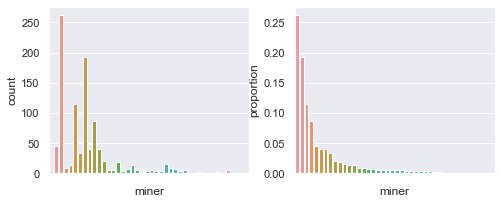

In [37]:
miners = db.cursor().execute('SELECT miner FROM Block').fetchall()
miners = [item[0] for item in miners]
df = pd.DataFrame({'miner': miners})

fig, ax = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
sns.countplot(df['miner'], ax=ax[0]).set(xticklabels=[], xlabel='miner')
(df['miner']
    .value_counts(normalize=True)
    .sort_values(ascending=False)
    .reset_index(name='proportion')
    .pipe((sns.barplot, 'data'), ax=ax[1], x = 'index', y = 'proportion') 
    .set(xticklabels=[], xlabel='miner')
 );
fig.show()

### How rewarding is it to mine a block?

The block rewards are nothing but the total gas paid by transactions. This number increases with the level of activity on the blockchain. For instance, during speculation mania, gas price needed to include a transaction in a block will be very high. 

Analyzing only 1000 blocks will not reveal the trend of block rewards over time (and their correlation with blockchain activity). However, I will simply plot the distribution of gas prices paid by individual transactions. Distribution has a long left tail. Few participants pay high gas prices.


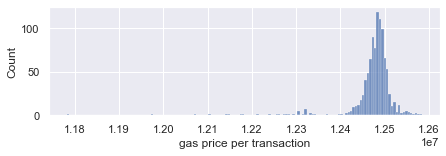

In [69]:
gu = db.cursor().execute('SELECT gasUsed FROM Block').fetchall()
gu = [i[0] for i in gu]
fig, ax = plt.subplots(figsize=(7, 2))
(sns.histplot(x = [item for item in gu if item > 1000000], ax = ax)
    .set(xlabel='gas price per transaction'));

### Transactions per block

Around 200 transactions are included in a block. This number should also increase as activity on the network increases. 


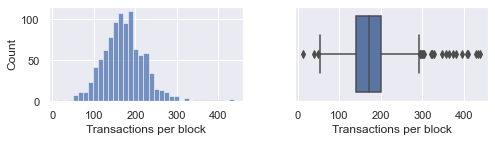

In [68]:
tpb = (db.cursor()
    .execute('SELECT blockNumber, count(txHash) FROM Tx GROUP BY blockNumber')
    .fetchall())

fig, ax = plt.subplots(1,2, figsize=(7,2))
fig.tight_layout()
(pd.DataFrame(tpb, columns = ['block_number', 'tx_count'])
    .pipe((sns.histplot, 'data'), x = 'tx_count', ax=ax[0])
    .set(xlabel='Transactions per block'))
(pd.DataFrame(tpb, columns = ['block_number', 'tx_count'])
    .pipe((sns.boxplot, 'data'), x = 'tx_count', ax=ax[1])
    .set(xlabel='Transactions per block'))
fig.show()

### Eth value transferred per transactions

Analyzing these 1000 blocks reveals that there were few high value transactions (50000 eth per transaction), but a vast majority of the transactions are low value.

In [60]:
values = db.cursor().execute('SELECT value FROM Tx')
vals = pd.Series([float(i[0]) / wei_per_eth for i 
    in values.fetchall() if float(i[0]) > 0])
vals.describe()

count    7.764300e+04
mean     9.806559e+00
std      2.909057e+02
min      1.000000e-18
25%      2.300000e-02
50%      1.000000e-01
75%      6.588125e-01
max      5.000000e+04
dtype: float64

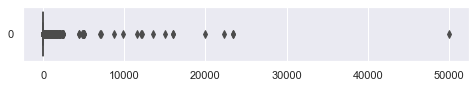

In [67]:
fig, ax = plt.subplots(figsize=(8, 1))
#seaborn.violinplot(ax=ax, data=df, **violin_options)
vals.where(lambda x: x > 0.1).pipe((sns.boxplot, 'data'), ax = ax, orient = 'h');

### How to calculate wallet balance?

To calculate the eth balance of a wallet address, we need all the transactions where this wallet address is either an input or an output of the transaction. Given only 1000 blocks in this database, we can still apply the same logic and compute the wallet balance assuming that our oldest block is equivalent to the genesis block. The wallet balance will not be correct, but the calculation procedure is still valid.

Find the 5 most frequently occuring wallets that appear in the input portion of the transaction, and calculate their eth balance.


In [25]:
for addr in db.cursor().execute('SELECT txTo, count(txTo) FROM Tx GROUP BY txTo \
                                    ORDER BY count(txTo) DESC LIMIT 5').fetchall():
    received = db.cursor().execute('SELECT value FROM Tx WHERE txTo=? AND value>0', 
                                        (addr[0],)).fetchall()
    received_amount = sum([float(s[0])/wei_per_eth for s in received])
    sent = db.cursor().execute('SELECT value FROM Tx WHERE txFrom=? AND value>0', 
                                        (addr[0],)).fetchall()
    sent_amount = sum([float(s[0])/wei_per_eth for s in sent])
    print('wallet address: {}, eth balance: {:.4f}'.format(addr[0], 
            received_amount - sent_amount))

wallet address: 0x7a250d5630B4cF539739dF2C5dAcb4c659F2488D, eth balance: 21766.1073
wallet address: 0xdAC17F958D2ee523a2206206994597C13D831ec7, eth balance: 0.0000
wallet address: 0xA090e606E30bD747d4E6245a1517EbE430F0057e, eth balance: 0.1353
wallet address: 0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48, eth balance: 0.0000
wallet address: 0x514910771AF9Ca656af840dff83E8264EcF986CA, eth balance: 0.0000


In [26]:
db.cursor().close()